# Import bibliotek

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar100

# Wczytywanie danych CIFAR-100

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')

169001437/169001437 [==============================] - 12s 0us/step


# Sprawdzenie rozmiaru danych

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Modyfikacja wymiaru danych

In [ ]:
import cv2

In [ ]:
X_train = np.array([cv2.resize(img, (96, 96)) for img in X_train])
X_test = np.array([cv2.resize(img, (96, 96)) for img in X_test])

# Kodowanie danych na postać binarną

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train=enc.fit_transform(y_train).toarray().astype(int)
y_test=enc.transform(y_test).toarray().astype(int)


print(y_train.shape)
print(y_train[0])

(50000, 20)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


# Preprocessing MobileNet_V2

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Pobranie MobileNet_V2

In [ ]:
IMG_SIZE = (96, 96)
IMG_SHAPE = IMG_SIZE + (3,)
MobileNet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
MobileNet.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

# Transfer learning Model MobileNet_V2 z dodaną jedną warstwą ukrytą

In [ ]:
def transfer_from_MN(image_shape=IMG_SIZE):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = preprocess_input(inputs)

    x = base_model(x, training=False)

    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.1)(x)

    outputs = tfl.Dense(units=20, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

## Transfer learning Model MobileNet_V2 z  dodanymi wieloma warstwami ukrytymi

In [ ]:
def transfer_from_MN_2(image_shape=IMG_SIZE):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = preprocess_input(inputs)

    x = base_model(x, training=False)

    x = tfl.GlobalAveragePooling2D()(x)

    x = tfl.Dropout(0.3)(x)

    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.Dense(units=100)(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Dropout(0.3)(x)

    outputs = tfl.Dense(units=20, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

# Trenowanie modeli

In [ ]:
    CIFAR_Recognizer_1 = transfer_from_MN(IMG_SIZE)
    CIFAR_Recognizer_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    CIFAR_Recognizer_2 = transfer_from_MN_2(IMG_SIZE)
    CIFAR_Recognizer_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
initial_epochs = 5

In [ ]:
history1 = CIFAR_Recognizer_1.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=initial_epochs, shuffle=True)

Epoch 1/5
782/782 [==============================] - 353s 448ms/step - loss: 1.1876 - accuracy: 0.6305 - val_loss: 0.9150 - val_accuracy: 0.7031
Epoch 2/5
782/782 [==============================] - 381s 487ms/step - loss: 0.8771 - accuracy: 0.7218 - val_loss: 0.8710 - val_accuracy: 0.7199
Epoch 3/5
782/782 [==============================] - 349s 446ms/step - loss: 0.8133 - accuracy: 0.7412 - val_loss: 0.8581 - val_accuracy: 0.7270
Epoch 4/5
782/782 [==============================] - 386s 494ms/step - loss: 0.7802 - accuracy: 0.7495 - val_loss: 0.8644 - val_accuracy: 0.7268
Epoch 5/5
782/782 [==============================] - 379s 485ms/step - loss: 0.7635 - accuracy: 0.7554 - val_loss: 0.8655 - val_accuracy: 0.7296


In [ ]:
history2 = CIFAR_Recognizer_2.fit(train_dataset, validation_data=test_dataset, batch_size=64, epochs=initial_epochs, shuffle=True)

Epoch 1/5
782/782 [==============================] - 354s 449ms/step - loss: 1.4981 - accuracy: 0.5364 - val_loss: 0.9811 - val_accuracy: 0.6862
Epoch 2/5
782/782 [==============================] - 351s 449ms/step - loss: 1.1695 - accuracy: 0.6328 - val_loss: 0.9052 - val_accuracy: 0.7098
Epoch 3/5
782/782 [==============================] - 355s 454ms/step - loss: 1.0919 - accuracy: 0.6545 - val_loss: 0.9005 - val_accuracy: 0.7077
Epoch 4/5
782/782 [==============================] - 353s 451ms/step - loss: 1.0512 - accuracy: 0.6674 - val_loss: 0.8757 - val_accuracy: 0.7161
Epoch 5/5
782/782 [==============================] - 354s 452ms/step - loss: 1.0248 - accuracy: 0.6773 - val_loss: 0.8662 - val_accuracy: 0.7184


# Krzywe uczenia modeli - loss

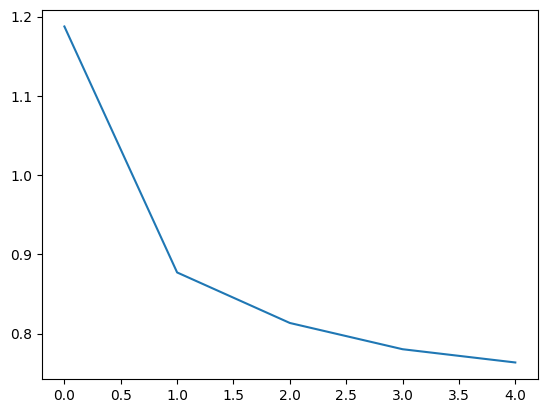

In [ ]:
plt.plot(history1.history["loss"])

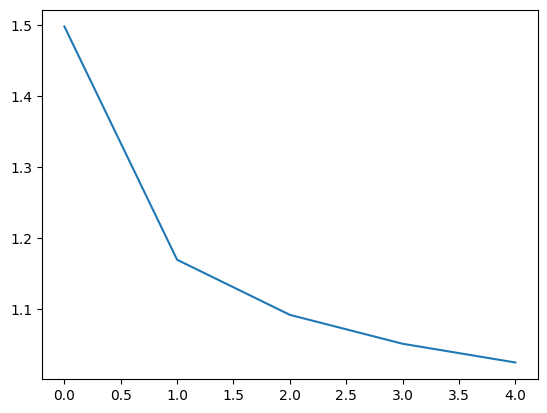

In [ ]:
plt.plot(history2.history["loss"])

# Krzywe uczenia modeli - accuracy

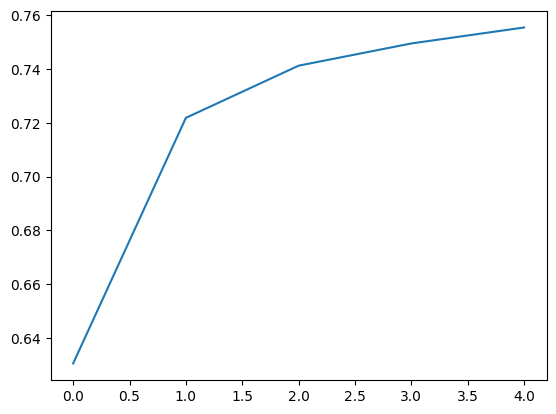

In [ ]:
plt.plot(history1.history["accuracy"])

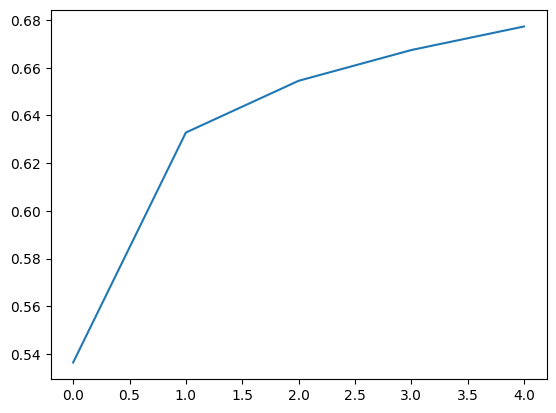

In [ ]:
plt.plot(history2.history["accuracy"])

# Predykcje modeli

In [ ]:
y_pred_1 = CIFAR_Recognizer_1.predict(X_test)
y_pred_2 = CIFAR_Recognizer_2.predict(X_test)

313/313 [==============================] - 52s 160ms/step


# Zamiana predykcji na nazwy klas

In [ ]:
y_pred_class_1 = np.argmax(y_pred_1, axis=1)
y_pred_class_2 = np.argmax(y_pred_2, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# Ewaluacja modeli - macierze konfuzji

In [ ]:
from tensorflow.keras.utils import to_categorical

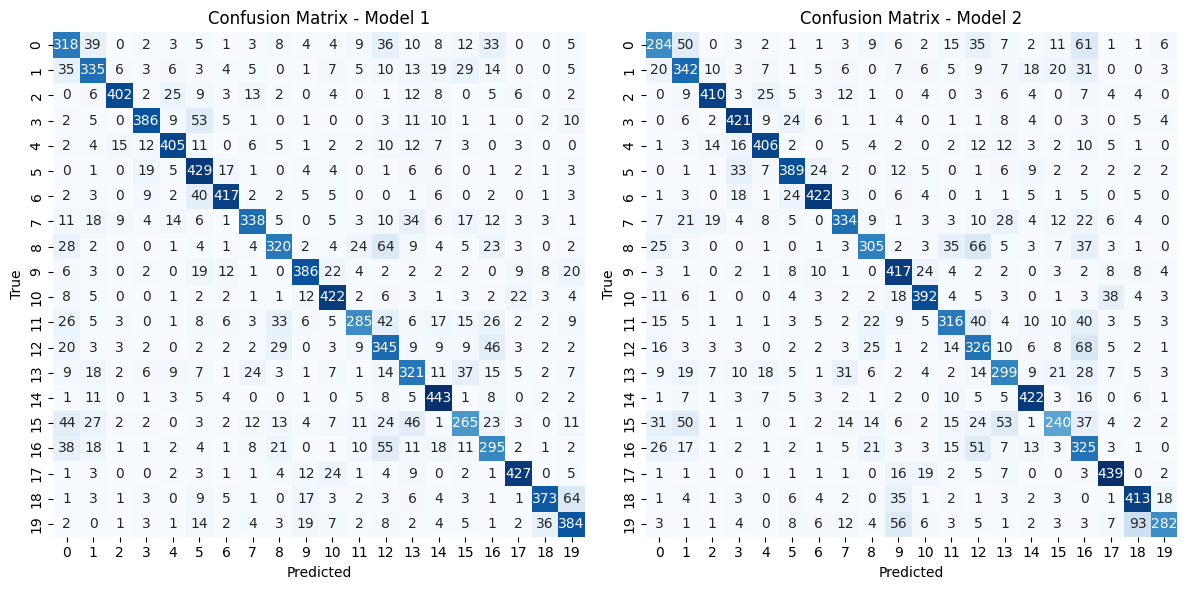

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_1 = confusion_matrix(y_true_class, y_pred_class_1)
cm_2 = confusion_matrix(y_true_class, y_pred_class_2)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Model 1')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Model 2')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Ewaluacja modeli - metryki

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score, roc_curve, auc

accuracy_1 = accuracy_score(y_true_class, y_pred_class_1)
accuracy_2 = accuracy_score(y_true_class, y_pred_class_2)

precision_1 = precision_score(y_true_class, y_pred_class_1, average='weighted')
precision_2 = precision_score(y_true_class, y_pred_class_2, average='weighted')

recall_1 = recall_score(y_true_class, y_pred_class_1, average='weighted')
recall_2 = recall_score(y_true_class, y_pred_class_2, average='weighted')

f2_1 = fbeta_score(y_true_class, y_pred_class_1, beta=2, average='weighted')
f2_2 = fbeta_score(y_true_class, y_pred_class_2, beta=2, average='weighted')

roc_auc_1 = roc_auc_score(to_categorical(y_true_class), y_pred_1, average='macro', multi_class='ovr')
roc_auc_2 = roc_auc_score(to_categorical(y_true_class), y_pred_2, average='macro', multi_class='ovr')

print("Model 1:")
print("Accuracy:", accuracy_1)
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F2 Score:", f2_1)
print("ROC AUC:", roc_auc_1)

print("\nModel 2:")
print("Accuracy:", accuracy_2)
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F2 Score:", f2_2)
print("ROC AUC:", roc_auc_2)

Model 1:
Accuracy: 0.7296
Precision: 0.736934024131068
Recall: 0.7296
F2 Score: 0.7290372912578021
ROC AUC: 0.9776263578947366

Model 2:
Accuracy: 0.7184
Precision: 0.7274246918549665
Recall: 0.7184
F2 Score: 0.7173054726315032
ROC AUC: 0.9771866947368422
